In [1]:
import repackage
repackage.up()
import sys
sys.path.append("..")
from datasets.nuscenes import NuScenesMultipleRadarMultiSweeps
import os
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points, transform_matrix

import os
import cv2
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_sps_labels(map, scan_points):
    labeled_map_points = map[:, :3]
    labeled_map_labels = map[:, -1]

    sps_labels = []
    for point in scan_points[:, :3]:
        distances = np.linalg.norm(labeled_map_points - point, axis=1)
        closest_point_idx = np.argmin(distances)
        sps_labels.append(labeled_map_labels[closest_point_idx])
    sps_labels = np.array(sps_labels)
    return sps_labels

In [3]:
def map_pointcloud_to_image(nusc,
                            sps_map,
                            pointsensor_token: str,
                            camera_token: str,
                            min_dist: float = 1.0):
    """
    Given a point sensor (lidar/radar) token and camera sample_data token, load pointcloud and map it to the image
    plane.
    :param pointsensor_token: Lidar/radar sample_data token.
    :param camera_token: Camera sample_data token.
    :param min_dist: Distance from the camera below which points are discarded.
    :param render_intensity: Whether to render lidar intensity instead of point depth.
    :param show_lidarseg: Whether to render lidar intensity instead of point depth.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
        or the list is empty, all classes will be displayed.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
    """

    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)

    pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
    pc = RadarPointCloud.from_file(pcl_path)
    im = Image.open(osp.join(nusc.dataroot, cam['filename']))
    

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))


    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    global_points = pc.points.T
    sps_score = get_sps_labels(sps_map, global_points)

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)
    
    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)


    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]
    coloring = sps_score

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    return points, coloring, im

def render_pointcloud_in_image(nusc,
                               sps_map,
                                sample_token: str,
                                dot_size: int = 5,
                                pointsensor_channel: str = 'LIDAR_TOP',
                                camera_channel: str = 'CAM_FRONT',
                                out_path: str = None,
                                ax = None,
                                verbose: bool = True):
    """
    Scatter-plots a pointcloud on top of image.
    :param sample_token: Sample token.
    :param dot_size: Scatter plot dot size.
    :param pointsensor_channel: RADAR or LIDAR channel name, e.g. 'LIDAR_TOP'.
    :param camera_channel: Camera channel name, e.g. 'CAM_FRONT'.
    :param out_path: Optional path to save the rendered figure to disk.
    :param render_intensity: Whether to render lidar intensity instead of point depth.
    :param show_lidarseg: Whether to render lidarseg labels instead of point depth.
    :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes.
    :param ax: Axes onto which to render.
    :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
    :param verbose: Whether to display the image in a window.
    :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                    predictions for the sample.
    :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
        to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        If show_lidarseg is True, show_panoptic will be set to False.
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    sample_record = nusc.get('sample', sample_token)


    # Here we just grab the front camera and the point sensor.
    pointsensor_token = nusc.get('sample_data', sample_record['data'][pointsensor_channel])['token'] # sample_record['data'][pointsensor_channel]
    camera_token = nusc.get('sample_data', sample_record['data'][camera_channel])['token'] # sample_record['data'][camera_channel]

    points, coloring, im = map_pointcloud_to_image(nusc, sps_map, pointsensor_token, camera_token)

    # Init axes.
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(9, 16))
        fig.canvas.set_window_title(sample_token)
    else:  # Set title on if rendering as part of render_sample.
        ax.set_title(camera_channel)
    ax.imshow(im)
    scatter = ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size, cmap='RdYlGn')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.axis('off')
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label("Stability (Max: 1)")

    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)
    if verbose:
        plt.show()

In [14]:
def setup_directories(base_dir, scene_name):
    os.makedirs(base_dir, exist_ok=True)
    os.makedirs(os.path.join(base_dir, scene_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, scene_name, 'frames'), exist_ok=True)

def save_plots_for_scene(nusc, base_dir, scene_name, sample_token, sps_map, num_sweeps=5):
    sample = nusc.get('sample', sample_token)
    frame_index = 0

    while sample_token:
        fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(16, 8), dpi=300)
        plot_path = os.path.join(base_dir, scene_name, 'frames', f'{frame_index}.png')
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
        
        top_pos = [0.05, 0.52, 0.9, 0.46]  # [left, bottom, width, height]
        bottom_pos = [0.05, 0.02, 0.9, 0.46]  # [left, bottom, width, height]

        nusc.render_sample_data(sample['data']['RADAR_FRONT'], nsweeps=num_sweeps, underlay_map=True, with_anns=True, ax=ax_top)
        # top_pos = ax_top.get_position()
        # ax_top.set_position([top_pos.x0, top_pos.y0, top_pos.width, top_pos.height])
        ax_top.set_position(top_pos)

        render_pointcloud_in_image(nusc, sps_map, sample['token'], pointsensor_channel='RADAR_FRONT', ax=ax_bottom)
        # bottom_pos = ax_bottom.get_position()
        # ax_bottom.set_position([bottom_pos.x0, bottom_pos.y0, bottom_pos.width, bottom_pos.height])
        ax_bottom.set_position(bottom_pos)
        
        ax_top.axis('off')
        ax_bottom.axis('off')

        # ax_top.set_title(f"Scene {scene_name} | KeyFrame {frame_index}", fontsize=12)
        plt.tight_layout()
        fig.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        # Move to next sample
        sample_token = sample['next']
        if sample_token:
            sample = nusc.get('sample', sample_token)
        frame_index += 1

def create_video_from_plots(base_dir, scene_name):
    plot_dir = os.path.join(base_dir, scene_name, 'frames')
    num_frames = len(os.listdir(plot_dir))
    sample_image = cv2.imread(os.path.join(plot_dir, '0.png'))

    
    height, width, _ = sample_image.shape
    
    video_height = height # 2 * size[1] # height1 + height2
    video_width = width
    
    out_video_path = os.path.join(base_dir, scene_name, f'{scene_name}.mp4')
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 5, (video_width, video_height))

    
    for i in range(num_frames):
        img = cv2.resize(cv2.imread(os.path.join(plot_dir, f'{i}.png')), (video_width, video_height))
        out.write(img)
    out.release()

In [5]:
data_dir = "/shared/data/nuScenes/"
sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
    for vname,version in versions.items()
}

In [6]:
import pandas as pd
sps_df = pd.read_json('../sps_nuscenes_more_matches_df.json')
sps_df.head()

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,1526922443042,0,0.000000,May,trainval,[scene-0218],{'scene-0218': {'scene_token': 'febc1800b9ed43...
122,scene-0162,1526922463034,0,0.005553,May,trainval,"[scene-0665, scene-0218, scene-0219]",{'scene-0665': {'scene_token': '45275e709d4a4b...
123,scene-0163,1526922483050,0,0.011113,May,trainval,"[scene-0075, scene-0511, scene-0332, scene-045...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,1526922518041,0,0.020833,May,trainval,"[scene-0513, scene-0091]",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,1526922555077,0,0.031121,May,trainval,"[scene-0092, scene-0333, scene-0265, scene-0062]",{'scene-0092': {'scene_token': '7365495b744646...


In [15]:
from tqdm import tqdm
import matplotlib
matplotlib.use('Agg')
plt.ioff()
import os.path as osp
from PIL import Image

sps_row = sps_df[sps_df['scene_name'] == 'scene-0168']

ref_frame = 'global'
num_sweeps = 5
ref_sensor = None
apply_dpr = False
filter_points = False
dpr_thresh = 0.5

for i,row in tqdm(sps_row.iterrows(), total=len(sps_row)):

    ref_scene_name = row['scene_name']
    ref_split = row['split']
    closest_scenes = row['closest_scenes_data']
    seq = int(ref_scene_name.split("-")[-1])

    dataset_sequence = NuScenesMultipleRadarMultiSweeps(
        data_dir=data_dir,
        nusc=nuscenes_exp[ref_split],
        sequence=seq,
        sensors=sensors,
        nsweeps=num_sweeps,
        ref_frame=ref_frame,
        ref_sensor=ref_sensor,
        apply_dpr=apply_dpr,
        filter_points=filter_points,
        ransac_threshold=dpr_thresh

    )


    labelled_map_path = "/home/umair/workspace/scene-0168_scene-0655_scene-0204_scene-0444_scene-0081_scene-0066_scene-0080_scene-0443_scene-0065_scene-0203.asc"
    sps_map = np.loadtxt(labelled_map_path, delimiter=' ', skiprows=1)
    sample_token = dataset_sequence.scene['first_sample_token']
    base_dir = 'output_videos'

    # setup_directories(base_dir, ref_scene_name)
    # save_plots_for_scene(nuscenes_exp[ref_split], base_dir, ref_scene_name, sample_token, sps_map)
    create_video_from_plots(base_dir, ref_scene_name)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion
from functools import reduce

def plot_scenes_comparison(nusc: NuScenes, scene1: str, scene2: str):
    def get_first_sample(scene_name):
        """Retrieve the first sample token for a given scene name."""
        for scene in nusc.scene:
            if scene['name'] == scene_name:
                return scene['first_sample_token']
        raise ValueError(f"Scene {scene_name} not found.")

    def aggregate_radar_pointcloud(sample_token, sweeps=5):
        """Aggregate radar data from all sensors and sweeps, transforming them to the ego frame."""
        sample = nusc.get('sample', sample_token)
        radar_sensors = ['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT']
        aggregated_points = []

        for sensor in radar_sensors:
            current_sample_data = nusc.get('sample_data', sample['data'][sensor])
            points = []

            for _ in range(sweeps):
                # Load radar data
                radar_path = nusc.get_sample_data_path(current_sample_data['token'])
                radar_pc = RadarPointCloud.from_file(radar_path)

                # Transform radar points to reference frame
                current_pose_rec = nusc.get('ego_pose', current_sample_data['ego_pose_token'])
                global_from_car = transform_matrix(
                    current_pose_rec['translation'], Quaternion(current_pose_rec['rotation']), inverse=False
                )

                current_cs_rec = nusc.get('calibrated_sensor', current_sample_data['calibrated_sensor_token'])
                car_from_current = transform_matrix(
                    current_cs_rec['translation'], Quaternion(current_cs_rec['rotation']), inverse=False
                )

                # Reference transformation (ego -> car -> global -> sensor)
                trans_matrix = reduce(
                    np.dot,
                    [
                        # global_from_car,
                        car_from_current,
                    ]
                )
                radar_pc.transform(trans_matrix)
                points.append(radar_pc.points[:3, :])

                # Move to the previous sweep if available
                if current_sample_data['prev']:
                    current_sample_data = nusc.get('sample_data', current_sample_data['prev'])
                else:
                    break

            # Concatenate sweeps for this sensor
            if points:
                aggregated_points.append(np.hstack(points))

        # Concatenate points from all sensors
        return np.hstack(aggregated_points) if aggregated_points else None

    def get_lidar_pointcloud(sample_token):
        """Retrieve LiDAR data for the sample."""
        sample = nusc.get('sample', sample_token)
        lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
        lidar_path = nusc.get_sample_data_path(lidar_data['token'])
        lidar_pc = LidarPointCloud.from_file(lidar_path)
        return lidar_pc.points[:2, :]

    def get_camera_image_path(sample_token):
        """Retrieve the front camera image path for the sample."""
        sample = nusc.get('sample', sample_token)
        cam_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        return nusc.get_sample_data_path(cam_data['token'])

    def plot_sensor(ax, pc=None, cam_img_path=None, is_lidar=False):
        """Plot sensor data."""
        if cam_img_path:
            img = plt.imread(cam_img_path)
            ax.imshow(img)
            ax.axis("off")
        elif pc is not None:
            ax.scatter(pc[0], pc[1], s=0.2, alpha=0.5)
            ax.axis("equal")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_title("Lidar" if is_lidar else "Radar")

    # Get first sample tokens for the scenes
    scene1_token = get_first_sample(scene1)
    scene2_token = get_first_sample(scene2)

    # Fetch data for scene 1
    radar1 = aggregate_radar_pointcloud(scene1_token)
    lidar1 = get_lidar_pointcloud(scene1_token)
    cam1 = get_camera_image_path(scene1_token)

    # Fetch data for scene 2
    radar2 = aggregate_radar_pointcloud(scene2_token)
    lidar2 = get_lidar_pointcloud(scene2_token)
    cam2 = get_camera_image_path(scene2_token)

    # Plot in a 3x2 grid
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    
    # Camera images
    plot_sensor(axes[0, 0], cam_img_path=cam1)
    plot_sensor(axes[0, 1], cam_img_path=cam2)
    
    # LiDAR point clouds
    plot_sensor(axes[1, 0], pc=lidar1, is_lidar=True)
    plot_sensor(axes[1, 1], pc=lidar2, is_lidar=True)
    
    # Radar point clouds
    plot_sensor(axes[2, 0], pc=radar1)
    plot_sensor(axes[2, 1], pc=radar2)

    plt.tight_layout()
    plt.show()

In [18]:
# data_dir = "/shared/data/nuScenes/"
# sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
# versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
# nuscenes_exp = {
#     vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
#     for vname,version in versions.items()
# }

In [20]:
import pandas as pd
df = pd.read_json("../sps_nuscenes_more_matches_df.json")

In [22]:
df[df.split == 'trainval'].sample(n=1)

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
39,scene-0042,1532408752618,63,1523.974882,July,trainval,"[scene-0124, scene-0966]",{'scene-0124': {'scene_token': 'bed8426a524d45...


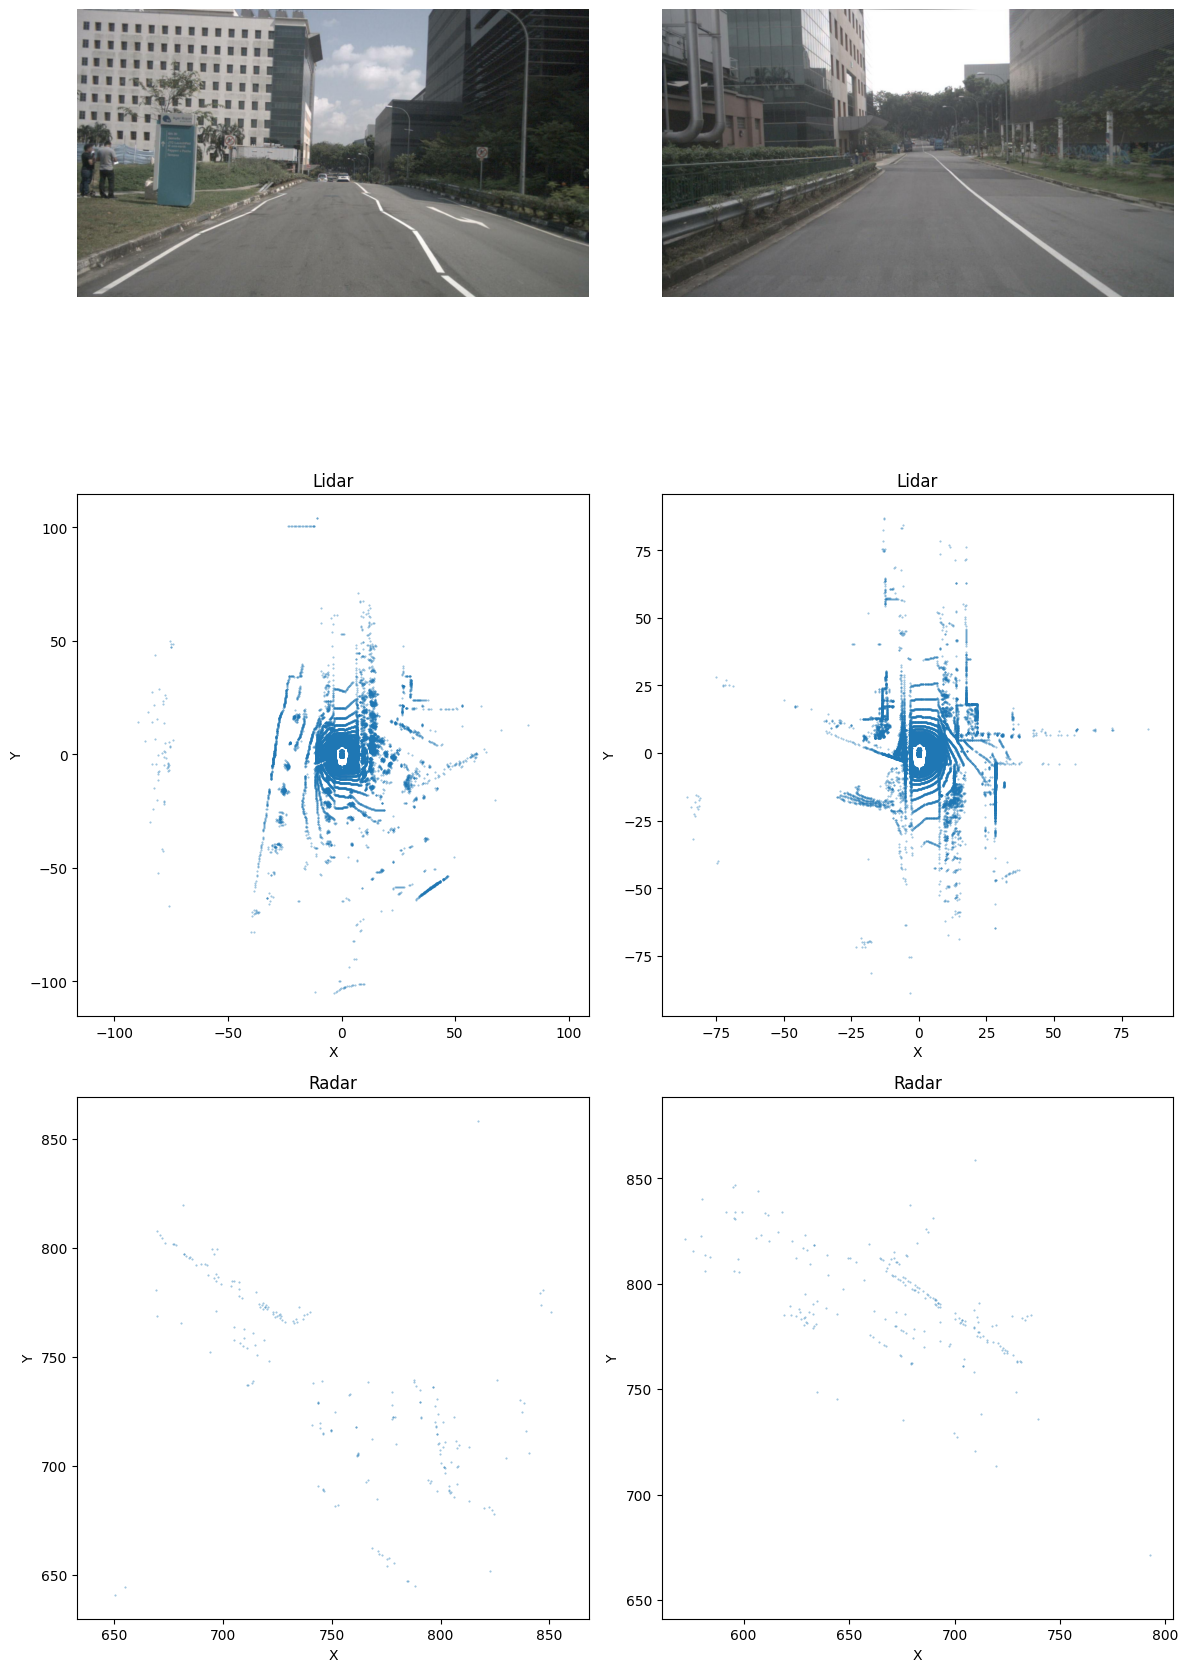

In [23]:
nusc = nuscenes_exp['trainval']
plot_scenes_comparison(nusc, 'scene-0042', 'scene-0124')